# Import libraries

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialise hyperparameters

In [2]:
batch_size = 160
train_fraction = 0.7
test_fraction = 1 - train_fraction
train_dropout_rate = 0.5
num_retrain = 5
epoch = 5000
n_estimators = 40
num_imputation = 5

# Helper functions

In [3]:
def xavier_initialisation(size):
    """
    Performs xavier initialisation on the weight matrix.
    """
    input_dim = size[0]
    xavier_stddev = tf.cast(1.0 / tf.sqrt(input_dim/2.0), dtype=tf.float32)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev, dtype=tf.float32)

In [4]:
def calculate_replication_loss(M, X, X_generated):
    """
    Calculate the cross entropy loss between the initially observed elements
    and the GAMIN-generated elements.
    """
    loss = X * tf.log(X_generated + 1e-8) + (1.0 - X) * tf.log(1.0 - X_generated + 1e-8)
    
    return M * loss

In [5]:
def sample_batch_index(train_size, batch_size):
    """
    Randomly sample a set of indices that is equal to the batch size.
    """
    unordered_index = np.random.permutation(train_size)
    
    return unordered_index[:batch_size]

In [6]:
def sample_Z(row, column):
    """
    Generates some random noise for the matrix Z.
    """
    return np.random.normal(size=(row, column))

In [7]:
def generator(X_with_noise, M, dropout_rate):
    """
    Feed-forward algorithm for the generator.
    """
    input_matrix = tf.concat(values=[X_with_noise, M], axis=1)
    Z_1 = tf.nn.leaky_relu(tf.matmul(input_matrix, G_W1) + G_b1)
    dropout_1 = tf.layers.dropout(inputs=Z_1, rate=dropout_rate)
    Z_2 = tf.nn.leaky_relu(tf.matmul(dropout_1, G_W2) + G_b2)
    dropout_2 = tf.layers.dropout(inputs=Z_2, rate=dropout_rate)
    Z_3 = tf.nn.leaky_relu(tf.matmul(dropout_2, G_W3) + G_b3)
    dropout_3 = tf.layers.dropout(inputs=Z_3, rate=dropout_rate)
    Z_4 = tf.nn.leaky_relu(tf.matmul(dropout_3, G_W4) + G_b4)
    dropout_4 = tf.layers.dropout(inputs=Z_4, rate=dropout_rate)
    Z_5 = tf.nn.leaky_relu(tf.matmul(dropout_4, G_W5) + G_b5)
    dropout_5 = tf.layers.dropout(inputs=Z_5, rate=dropout_rate)
    Z_6 = tf.nn.sigmoid(tf.matmul(dropout_5, G_W6) + G_b6)
    
    return Z_6  # returns a matrix containing values between 0 and 1

In [8]:
def discriminator(X_imputed, dropout_rate):
    """
    Feed-forward algorithm for the discriminator.
    """
    Z_1 = tf.nn.leaky_relu(tf.matmul(X_imputed, D_W1) + D_b1)
    dropout_1 = tf.layers.dropout(inputs=Z_1, rate=dropout_rate)
    Z_2 = tf.nn.leaky_relu(tf.matmul(dropout_1, D_W2) + D_b2)
    dropout_2 = tf.layers.dropout(inputs=Z_2, rate=dropout_rate)
    Z_3 = tf.nn.leaky_relu(tf.matmul(dropout_2, D_W3) + D_b3)
    dropout_3 = tf.layers.dropout(inputs=Z_3, rate=dropout_rate)
    Z_4 = tf.nn.sigmoid(tf.matmul(dropout_3, D_W4) + D_b4)
    
    return Z_4  # returns a probability matrix indicating each cell's likelihood of being initially observed

# Import data

In [35]:
data = pd.read_csv('processed_data.csv')

# Remove input features that exceed a certain missing rate

In [10]:
# Set a cutoff value such that any input feature with a missing rate greater than this value will be dropped.
cutoff_value = 1.0
original_data = pd.read_csv('data.csv')
dropped_columns = ['Day Of Week','Vehicle Reg No','Parking Duration','Place Type','Entry Month','Entry Day','Entry Year','Source']
original_data.drop(columns=dropped_columns, inplace=True)
missing_rate = original_data.isnull().sum()/len(original_data)

dropped_features = []
for i in range(len(missing_rate)):
    if missing_rate[i] > cutoff_value:
        dropped_features.append(missing_rate.keys()[i])

remaining_features_unordered = list(set(missing_rate.keys()) - set(dropped_features))
remaining_features = [feature for feature in missing_rate.keys() if feature in remaining_features_unordered]

print('Original list of input features:')
print(list(missing_rate.keys()))
print()
print('Input features that will be dropped:')
print(dropped_features)
print()
print('Final list of input features:')
print(remaining_features)

remaining_columns = []
if 'Mall' in remaining_features:
    remaining_columns.extend([0,1,2,3,4,5,6,7,8])
if 'Entry Hour' in remaining_features:
    remaining_columns.extend([9,10,11,12,13,14,15,16,17,18,19,20,21,22])
if 'Parking Location' in remaining_features:
    remaining_columns.extend([23,24,25])
if 'Vehicle Type' in remaining_features:
    remaining_columns.extend([26,27])
if 'Activity' in remaining_features:
    remaining_columns.extend([28,29,30,31])
if 'Refrigerated' in remaining_features:
    remaining_columns.extend([32,33])
if 'Commodity' in remaining_features:
    remaining_columns.extend([34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
if 'Payload(%)' in remaining_features:
    remaining_columns.extend([49,50,51,52])
if 'Initial Payload(%)' in remaining_features:
    remaining_columns.extend([53,54,55,56])
if 'Delivery Volume(m3)' in remaining_features:
    remaining_columns.extend([57,58,59,60])
if 'Pickup Volume(m3)' in remaining_features:
    remaining_columns.extend([61,62,63,64])
if 'Single/Bundle' in remaining_features:
    remaining_columns.extend([65])
if 'No of Workers' in remaining_features:
    remaining_columns.extend([66,67,68])
if 'Store Count' in remaining_features:
    remaining_columns.extend([69,70])
if 'Mall Count' in remaining_features:
    remaining_columns.extend([71,72,73,74])
if 'Employer' in remaining_features:
    remaining_columns.extend([75,76,77,78,79,80])
if 'No of Tours' in remaining_features:
    remaining_columns.extend([81,82,83])
if 'Is Service Vehicle' in remaining_features:
    remaining_columns.extend([84])
if 'No of Stops/Tour' in remaining_features:
    remaining_columns.extend([85,86,87,88])
if 'System Occupancy' in remaining_features:
    remaining_columns.extend([89,90,91,92])

Original list of input features:
['Mall', 'Entry Hour', 'Parking Location', 'Vehicle Type', 'Activity', 'Refrigerated', 'Commodity', 'Payload(%)', 'Initial Payload(%)', 'Delivery Volume(m3)', 'Pickup Volume(m3)', 'Single/Bundle', 'No of Workers', 'Store Count', 'Mall Count', 'Employer', 'No of Tours', 'No of Stops/Tour', 'Is Service Vehicle', 'System Occupancy']

Input features that will be dropped:
[]

Final list of input features:
['Mall', 'Entry Hour', 'Parking Location', 'Vehicle Type', 'Activity', 'Refrigerated', 'Commodity', 'Payload(%)', 'Initial Payload(%)', 'Delivery Volume(m3)', 'Pickup Volume(m3)', 'Single/Bundle', 'No of Workers', 'Store Count', 'Mall Count', 'Employer', 'No of Tours', 'No of Stops/Tour', 'Is Service Vehicle', 'System Occupancy']


# Define model variables

In [11]:
input_data = data.drop(columns=['Normalised_ParkingDuration','Parking Duration'])
output = data['Parking Duration']

# Data dimension
data_size = len(data)
input_dimension = len(input_data.loc[0,:])

# Hidden layer dimension (the dimension in the hidden layer is an average of the input and output dimensions)
hidden_dim_1 = int(input_dimension * 1.5)
hidden_dim_2 = int(input_dimension * 1.5)
hidden_dim_3 = int(input_dimension * 1.5)
hidden_dim_4 = int(input_dimension * 1.5)
hidden_dim_5 = int(input_dimension * 1.5)

# Extract mask matrix M

In [12]:
mask_matrix = np.invert(np.isnan(input_data)) * 1.0
input_data[np.isnan(input_data)] = 0  # missing elements are given an arbitrary value of 0

# Perform train test split

In [13]:
# Extract train and test index
index = np.random.permutation(data_size)
train_size = int(data_size * train_fraction)
test_size = data_size - train_size
train_index = index[:train_size].tolist()
test_index = index[train_size:].tolist()

# Extract train and test data using their corresponding indices
X_train = input_data.loc[train_index,:].values
Y_train = output[train_index].values
X_test = input_data.loc[test_index,:].values
Y_test = output[test_index].values

# Extract mask matrix for train and test data
M_train = mask_matrix.loc[train_index,:].values
M_test = mask_matrix.loc[test_index,:].values

# GAMIN architecture setup

## Define placeholders

In [14]:
X = tf.placeholder(tf.float32, shape=(None, input_dimension))  # data matrix
M = tf.placeholder(tf.float32, shape=(None, input_dimension))  # mask matrix
X_with_noise = tf.placeholder(tf.float32, shape=(None, input_dimension))  # data matrix imputed with noise
dropout_rate = tf.placeholder(tf.float32, shape=())

## Define variables

In [15]:
# Initialise weights for discriminator
D_W1 = tf.Variable(xavier_initialisation([input_dimension, hidden_dim_1]))
D_W2 = tf.Variable(xavier_initialisation([hidden_dim_1, hidden_dim_2]))
D_W3 = tf.Variable(xavier_initialisation([hidden_dim_2, hidden_dim_3]))
D_W4 = tf.Variable(xavier_initialisation([hidden_dim_3, input_dimension]))
D_b1 = tf.Variable(tf.random_normal(shape=[hidden_dim_1]))
D_b2 = tf.Variable(tf.random_normal(shape=[hidden_dim_2]))
D_b3 = tf.Variable(tf.random_normal(shape=[hidden_dim_3]))
D_b4 = tf.Variable(tf.random_normal(shape=[input_dimension]))
D_theta = [D_W1, D_W2, D_W3, D_W4, D_b1, D_b2, D_b3, D_b4]

In [16]:
# Initialise weights for generator
G_W1 = tf.Variable(xavier_initialisation([input_dimension*2, hidden_dim_1]))
G_W2 = tf.Variable(xavier_initialisation([hidden_dim_1, hidden_dim_2]))
G_W3 = tf.Variable(xavier_initialisation([hidden_dim_2, hidden_dim_3]))
G_W4 = tf.Variable(xavier_initialisation([hidden_dim_3, hidden_dim_4]))
G_W5 = tf.Variable(xavier_initialisation([hidden_dim_4, hidden_dim_5]))
G_W6 = tf.Variable(xavier_initialisation([hidden_dim_5, input_dimension]))
G_b1 = tf.Variable(tf.random_normal(shape=[hidden_dim_1]))
G_b2 = tf.Variable(tf.random_normal(shape=[hidden_dim_2]))
G_b3 = tf.Variable(tf.random_normal(shape=[hidden_dim_3]))
G_b4 = tf.Variable(tf.random_normal(shape=[hidden_dim_4]))
G_b5 = tf.Variable(tf.random_normal(shape=[hidden_dim_5]))
G_b6 = tf.Variable(tf.random_normal(shape=[input_dimension]))
G_theta = [G_W1, G_W2, G_W3, G_W4, G_W5, G_W6, G_b1, G_b2, G_b3, G_b4, G_b5, G_b6]

## Define operations

In [17]:
# Generate imputed matrix using generator
X_generated = generator(X_with_noise, M, dropout_rate)

In [18]:
# Combine generated matrix with original input matrix
X_imputed = X_with_noise * M + X_generated * (1-M)

In [19]:
# Discriminate between imputed and original values
prediction_matrix = discriminator(X_imputed, dropout_rate)

## Define loss functions for generator and discriminator

In [20]:
# Loss function for generator
"""
Generator is trained to be good at tricking the discriminator into thinking that an imputed value is observed,
and at the same time, good at reconstructing the initially observed values.
"""
G_imputation_loss = (1 - M) * tf.log(prediction_matrix + 1e-8)
G_replication_loss = calculate_replication_loss(M, X, X_generated)
G_loss = -tf.reduce_mean(G_imputation_loss + G_replication_loss)

In [21]:
# Loss function for discriminator 
"""
Discriminator is trained to be good at identifying which element is observed (p=1) and which is imputed (p=0)
"""
D_loss = -tf.reduce_mean(M * tf.log(prediction_matrix + 1e-8) + (1-M) * tf.log(1.0 - prediction_matrix + 1e-8))

## Define solvers for generator and discriminator

In [22]:
D_solver = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss=D_loss, var_list=D_theta)
G_solver = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=G_loss, var_list=G_theta)

## Initialise Tensorflow session and global variables

In [23]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

## Prepare test dataset

In [24]:
Z_test = sample_Z(test_size, input_dimension)
X_with_noise_test = M_test * X_test + (1 - M_test) * Z_test

## Initialise some empty lists to keep track of training progress

In [25]:
train_G_replication_loss = []
train_G_imputation_loss = []
train_G_loss = []
train_D_loss = []
train_r2_score = []
train_RMSE_score = []
train_MAE_score = []
train_MI_r2_score = []
train_MI_RMSE_score = []
train_MI_MAE_score = []

test_G_replication_loss = []
test_G_imputation_loss = []
test_G_loss = []
test_D_loss = []
test_r2_score = []
test_RMSE_score = []
test_MAE_score = []
test_MI_r2_score = []
test_MI_RMSE_score = []
test_MI_MAE_score = []

## Begin model training

In [26]:
for iteration in tqdm(range(epoch)):
    if iteration % 100 != 0:  # training step
        for i in range(num_retrain):  # updating weights for generator network
            # Prepare batch input
            batch_index = sample_batch_index(train_size, batch_size)
            X_batch = X_train[batch_index, :]
            M_batch = M_train[batch_index, :]
            Z_batch = sample_Z(batch_size, input_dimension)
            X_with_noise_batch = M_batch * X_batch + (1 - M_batch) * Z_batch
            sess.run(fetches=[G_solver], feed_dict={X:X_batch, M:M_batch, X_with_noise:X_with_noise_batch, dropout_rate:train_dropout_rate})
        
        #  updating weights for discriminator network
        sess.run(fetches=[D_solver], feed_dict={M:M_batch, X_with_noise:X_with_noise_batch, dropout_rate: train_dropout_rate})
    
    else:  # perform imputation using the current generator and train a regression model based on imputed results
        # initialise some empty lists to store the results for each round of imputation
        train_replication_loss_store = []
        train_imputation_loss_store = []
        train_G_loss_store = []
        train_D_loss_store = []
        test_replication_loss_store = []
        test_imputation_loss_store = []
        test_G_loss_store = []
        test_D_loss_store = []
        
        for i in range(num_retrain):
            # Prepare batch input
            batch_index = sample_batch_index(train_size, batch_size)
            X_batch = X_train[batch_index, :]
            M_batch = M_train[batch_index, :]
            Z_batch = sample_Z(batch_size, input_dimension)
            X_with_noise_batch = M_batch * X_batch + (1 - M_batch) * Z_batch 
            
            # Train solver and store training progress
            _, train_replication_loss, train_imputation_loss, train_generator_loss = sess.run(fetches=[G_solver, G_replication_loss, G_imputation_loss, G_loss], feed_dict={X:X_batch, M:M_batch, X_with_noise:X_with_noise_batch, dropout_rate:train_dropout_rate})
            _, train_discriminator_loss = sess.run(fetches=[D_solver, D_loss], feed_dict={M:M_batch, X_with_noise:X_with_noise_batch, dropout_rate:train_dropout_rate})
            
            test_replication_loss, test_imputation_loss, test_generator_loss = sess.run(fetches=[G_replication_loss, G_imputation_loss, G_loss], feed_dict={X:X_test, M:M_test, X_with_noise:X_with_noise_test, dropout_rate:0.0})
            test_discriminator_loss = sess.run(fetches=D_loss, feed_dict={M:M_test, X_with_noise:X_with_noise_test, dropout_rate:0.0})

            # Store loss results for each imputation in MI
            train_replication_loss_store.append(-np.mean(train_replication_loss))
            train_imputation_loss_store.append(-np.mean(train_imputation_loss))
            train_G_loss_store.append(train_generator_loss)
            train_D_loss_store.append(train_discriminator_loss)
            
            test_replication_loss_store.append(-np.mean(test_replication_loss))
            test_imputation_loss_store.append(-np.mean(test_imputation_loss))
            test_G_loss_store.append(test_generator_loss)
            test_D_loss_store.append(test_discriminator_loss)
        
        # Calculate the average loss based on all of the rounds of imputation that has been carried out
        train_G_replication_loss.append(np.mean(train_replication_loss_store))
        train_G_imputation_loss.append(np.mean(train_imputation_loss_store))
        train_G_loss.append(np.mean(train_G_loss_store))
        train_D_loss.append(np.mean(train_D_loss_store))
        
        test_G_replication_loss.append(np.mean(test_replication_loss_store))
        test_G_imputation_loss.append(np.mean(test_imputation_loss_store))
        test_G_loss.append(np.mean(test_G_loss_store))
        test_D_loss.append(np.mean(test_D_loss_store))
    
        # Train a regression model based on the imputed results and perform prediction
        for i in range(num_imputation):
            Z_train = sample_Z(train_size, input_dimension)
            X_with_noise_train = M_train * X_train + (1 - M_train) * Z_train
            
            train_imputed_matrix = X_imputed.eval(feed_dict={M:M_train, X_with_noise:X_with_noise_train, dropout_rate:0.0})
            test_imputed_matrix = X_imputed.eval(feed_dict={M:M_test, X_with_noise:X_with_noise_test, dropout_rate:0.0})
            
            gb_model = GradientBoostingRegressor(n_estimators=n_estimators).fit(train_imputed_matrix[:,remaining_columns], Y_train)
            
            if i == 0:
                Y_train_predict = gb_model.predict(train_imputed_matrix[:,remaining_columns])
                train_MAE_score.append(mean_absolute_error(Y_train, Y_train_predict))
                train_RMSE_score.append(mean_squared_error(Y_train, Y_train_predict) ** 0.5)
                train_r2_score.append(r2_score(Y_train, Y_train_predict))
                
                Y_test_predict = gb_model.predict(test_imputed_matrix[:,remaining_columns])
                test_MAE_score.append(mean_absolute_error(Y_test, Y_test_predict))
                test_RMSE_score.append(mean_squared_error(Y_test, Y_test_predict) ** 0.5)
                test_r2_score.append(r2_score(Y_test, Y_test_predict))
            else:
                Y_train_predict += gb_model.predict(train_imputed_matrix[:,remaining_columns])
                Y_test_predict += gb_model.predict(test_imputed_matrix[:,remaining_columns])
        
        train_MI_MAE_score.append(mean_absolute_error(Y_train, Y_train_predict/float(num_imputation)))
        train_MI_RMSE_score.append(mean_squared_error(Y_train, Y_train_predict/float(num_imputation)) ** 0.5)
        train_MI_r2_score.append(r2_score(Y_train, Y_train_predict/float(num_imputation)))
        
        test_MI_MAE_score.append(mean_absolute_error(Y_test, Y_test_predict/float(num_imputation)))
        test_MI_RMSE_score.append(mean_squared_error(Y_test, Y_test_predict/float(num_imputation)) ** 0.5)
        test_MI_r2_score.append(r2_score(Y_test, Y_test_predict/float(num_imputation)))

100%|██████████| 5000/5000 [06:44<00:00, 13.86it/s]


## Visualise training progress

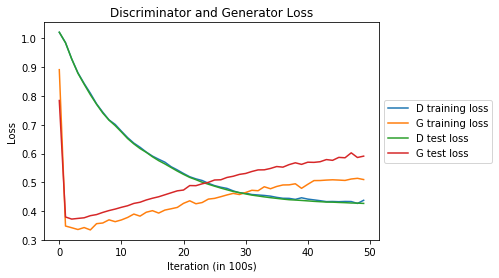

In [34]:
# Plot discriminator and generator loss
fig1, ax1 = plt.subplots()
fig1 = sns.lineplot(x=list(range(0, len(train_D_loss))), y=train_D_loss, ax=ax1, label='D training loss')
fig1 = sns.lineplot(x=list(range(0, len(train_G_loss))), y=train_G_loss, ax=ax1, label='G training loss')
fig1 = sns.lineplot(x=list(range(0, len(test_D_loss))), y=test_D_loss, ax=ax1, label='D test loss')
fig1 = sns.lineplot(x=list(range(0, len(test_G_loss))), y=test_G_loss, ax=ax1, label='G test loss')
fig1 = plt.title('Discriminator and Generator Loss')
fig1 = plt.ylabel('Loss')
fig1 = plt.xlabel('Iteration (in 100s)')
fig1 = ax1.legend(bbox_to_anchor=(1, 0.5), loc='center left',)

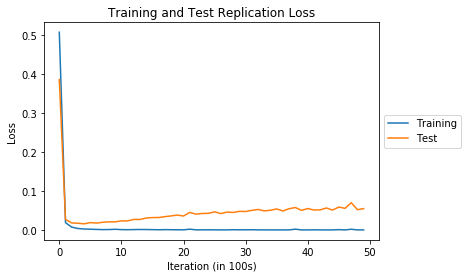

In [28]:
# Plot training and test replication loss
fig2, ax2 = plt.subplots()
fig2 = sns.lineplot(x=list(range(0, len(train_G_replication_loss))), y=train_G_replication_loss, ax=ax2, label='Training')
fig2 = sns.lineplot(x=list(range(0, len(test_G_replication_loss))), y=test_G_replication_loss, ax=ax2, label='Test')
fig2 = plt.title('Training and Test Replication Loss')
fig2 = plt.ylabel('Loss')
fig2 = plt.xlabel('Iteration (in 100s)')
fig2 = ax2.legend(bbox_to_anchor=(1, 0.5), loc='center left',)

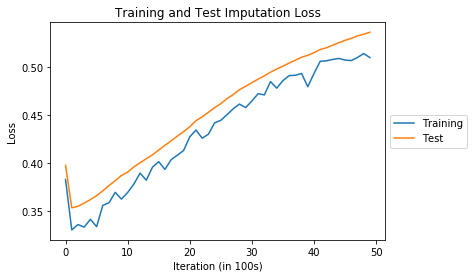

In [29]:
# Plot training and test imputation loss
fig3, ax3 = plt.subplots()
fig3 = sns.lineplot(x=list(range(0, len(train_G_imputation_loss))), y=train_G_imputation_loss, ax=ax3, label='Training')
fig3 = sns.lineplot(x=list(range(0, len(test_G_imputation_loss))), y=test_G_imputation_loss, ax=ax3, label='Test')
fig3 = plt.title('Training and Test Imputation Loss')
fig3 = plt.ylabel('Loss')
fig3 = plt.xlabel('Iteration (in 100s)')
fig3 = ax3.legend(bbox_to_anchor=(1, 0.5), loc='center left',)

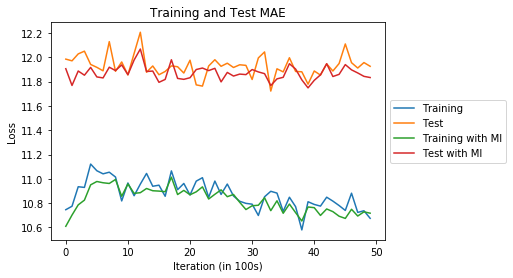

In [30]:
# Plot training and test mean absolute error score
fig4, ax4 = plt.subplots()
fig4 = sns.lineplot(x=list(range(0, len(train_MAE_score))), y=train_MAE_score, ax=ax4, label='Training')
fig4 = sns.lineplot(x=list(range(0, len(test_MAE_score))), y=test_MAE_score, ax=ax4, label='Test')
fig4 = sns.lineplot(x=list(range(0, len(train_MI_MAE_score))), y=train_MI_MAE_score, ax=ax4, label='Training with MI')
fig4 = sns.lineplot(x=list(range(0, len(test_MI_MAE_score))), y=test_MI_MAE_score, ax=ax4, label='Test with MI')
fig4 = plt.title('Training and Test MAE')
fig4 = plt.ylabel('Loss')
fig4 = plt.xlabel('Iteration (in 100s)')
fig4 = ax4.legend(bbox_to_anchor=(1, 0.5), loc='center left',)

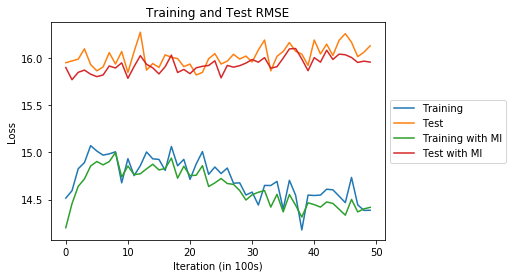

In [31]:
# Plot training and test root mean square error score
fig5, ax5 = plt.subplots()
fig5 = sns.lineplot(x=list(range(0, len(train_RMSE_score))), y=train_RMSE_score, ax=ax5, label='Training')
fig5 = sns.lineplot(x=list(range(0, len(test_RMSE_score))), y=test_RMSE_score, ax=ax5, label='Test')
fig5 = sns.lineplot(x=list(range(0, len(train_MI_RMSE_score))), y=train_MI_RMSE_score, ax=ax5, label='Training with MI')
fig5 = sns.lineplot(x=list(range(0, len(test_MI_RMSE_score))), y=test_MI_RMSE_score, ax=ax5, label='Test with MI')
fig5 = plt.title('Training and Test RMSE')
fig5 = plt.ylabel('Loss')
fig5 = plt.xlabel('Iteration (in 100s)')
fig5 = ax5.legend(bbox_to_anchor=(1, 0.5), loc='center left',)

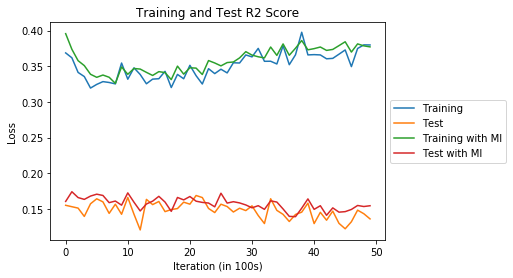

In [32]:
# Plot training and test R2 score
fig6, ax6 = plt.subplots()
fig6 = sns.lineplot(x=list(range(0, len(train_r2_score))), y=train_r2_score, ax=ax6, label='Training')
fig6 = sns.lineplot(x=list(range(0, len(test_r2_score))), y=test_r2_score, ax=ax6, label='Test')
fig6 = sns.lineplot(x=list(range(0, len(train_MI_r2_score))), y=train_MI_r2_score, ax=ax6, label='Training with MI')
fig6 = sns.lineplot(x=list(range(0, len(test_MI_r2_score))), y=test_MI_r2_score, ax=ax6, label='Test with MI')
fig6 = plt.title('Training and Test R2 Score')
fig6 = plt.ylabel('Loss')
fig6 = plt.xlabel('Iteration (in 100s)')
fig6 = ax6.legend(bbox_to_anchor=(1, 0.5), loc='center left',)

In [33]:
# Plot final training and test results
print('Final Training MAE: {}'.format(train_MI_MAE_score[-1]))
print('Final Test MAE: {}'.format(test_MI_MAE_score[-1]))
print()
print('Final Training MSE: {}'.format(train_MI_RMSE_score[-1]))
print('Final Test MSE: {}'.format(test_MI_RMSE_score[-1]))
print()
print('Final Training R2: {}'.format(train_MI_r2_score[-1]))
print('Final Test R2: {}'.format(test_MI_r2_score[-1]))

Final Training MAE: 10.717231785739692
Final Test MAE: 11.833920961778109

Final Training MSE: 14.417679651027143
Final Test MSE: 15.956587585983307

Final Training R2: 0.3771158397527592
Final Test R2: 0.1544013923801546
